# bunching estimation using the real data

take concept from simulation

In [88]:
# load packages

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from scipy.optimize import fsolve
from scipy import integrate
from sympy import symbols, solve, Eq
import re
import random
import tools # this imports the file tools.py // must be in the same folder as the current file


In [2]:
# define parameters
#pi = 2000
phi = 50/60
phi120 = 100/60

In [46]:
# load data
wd = Path.cwd()
file = 'stata/Outages_{period}.dta'
data = pd.read_stata(wd.parent/file) # convert_categoricals = True
print(data.columns)

# keep relevant columns
#data = data[['date', 'duration_minutes', 'discom', 'planned', 'noofcustomersaffected', 'unservedmuduetooutage', 'q']]
data['year'] = data.apply(lambda row: row.date.year, axis=1)

# keep year 2019
data = data[data.apply(lambda row: row.date.year == 2019, axis=1)]

# keep only unplanned
data = data.loc[data.planned != 'planned',]

# at least 100 custumers affected
data = data.loc[data.noofcustomersaffected >= 100]

data.reset_index(drop = True)


# keep one firm
#data = data.loc[data.discom == 'tata',]
data.head()

Index(['division_name', 'id', 'area_affected', 'noofcustomersaffected',
       'capacity', 'duration', 'unservedmuduetooutage', 'remarks', 'date',
       'end_date', 'start_date', 'end_time', 'start_time', 'hour_of_day',
       'duration_seconds', 'duration_minutes', 'duration_hours', 'discom',
       'planned', 'industrial', 'school', 'hospital', 'dairy', 'residential',
       'minute_of_day', 'q', 'quarter', 'hourly'],
      dtype='object')


,division_name,id,area_affected,noofcustomersaffected,capacity,duration,unservedmuduetooutage,remarks,date,end_date,...,industrial,school,hospital,dairy,residential,minute_of_day,q,quarter,hourly,year
0,alaknanda,1.0,"part off dsidc okhla phase‐1,",312.0,other outage,0:43,0.000005,outage due to\nfault,2019-12-02,2019-12-02,...,0.0,0.0,0.0,0.0,0.0,31.0,3.0,49898.0,16993.0,2019.0
1,alaknanda,2.0,"part off indira kalyan vihar okhla phase‐1,",314.0,other outage,0:09,0.000017,outage due to\nfault,2019-12-03,2019-12-03,...,0.0,0.0,0.0,0.0,0.0,30.0,3.0,49924.0,17003.0,2019.0
2,alaknanda,3.0,"part off b‐block kalka ji,e‐block kalka ji,f‐b...",303.0,other outage,0:57,0.000633,outage due to fault,2019-12-05,2019-12-05,...,0.0,0.0,0.0,0.0,0.0,19.0,2.0,50008.0,17036.0,2019.0
3,alaknanda,4.0,"part off railway yard,",302.0,other outage,0:37,0.000319,outage due to\nfault,2019-12-06,2019-12-06,...,0.0,0.0,0.0,0.0,0.0,21.0,2.0,50072.0,17060.0,2019.0
4,alaknanda,5.0,"part off cng station okhla phase‐1,a‐block okh...",140.0,other outage,0:33,0.000413,outage due to fault,2019-12-06,2019-12-06,...,1.0,0.0,0.0,0.0,0.0,30.0,3.0,50063.0,17057.0,2019.0


(-0.2, 4.2, -3.5766582546655457, 82.64946879770696)

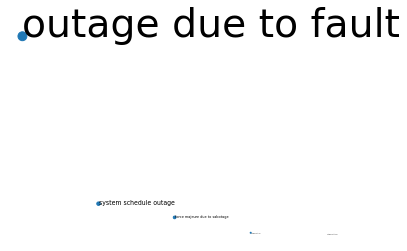

In [149]:
data['remark_short'] = data.apply(lambda row: row.remarks.replace('\n', ' '), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: row.remark_short.strip(), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: re.sub(' +', ' ',row.remark_short), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: row.remark_short.replace('trafic', 'traffic'), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: 'outage due to rain' if row.remark_short.__contains__('rain') else row.remark_short, axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: 'outage due to fault' if row.remark_short.__contains__('fault') else row.remark_short, axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: 'outage due to traffic' if row.remark_short.__contains__('traffic') else row.remark_short, axis = 1)

# most remarks
remarks = data.remark_short[(data.remark_short != '.') & (data.remark_short != '')].value_counts(normalize = True)[0:5]

df = pd.DataFrame(remarks.index.tolist(), columns=['remark'])
df['counts'] = remarks.values * 100
df


plt.scatter(df.remark, df.counts, s = 0 ) # s = np.round(df.counts.tolist())
lab = df.remark.tolist()
for i,l in enumerate(lab):
    plt.annotate(l, xy = (df.remark[i],df.counts[i]), size = df.counts.tolist()[i]/2)

#plt.ylim(-10, df.counts.max()+10)
#plt.xticks([])
plt.axis('off')

#plt.savefig('remarks.png', dpi=120, format='png')

In [19]:
## calculate pi

tariff = 7

pi_avg = (data.unservedmuduetooutage.mean() * 1000000/ data.duration_minutes.mean() ) * tariff

pi_median = (data.unservedmuduetooutage.median() * 1000000/ data.duration_minutes.median() ) * tariff

print('using averages:', pi_avg, '\n', 'using medians:', pi_median)

# replace pi
pi = pi_avg


using averages: 72.19330119307926 
 using medians: 47.87234042553192


(0.0, 420.0)

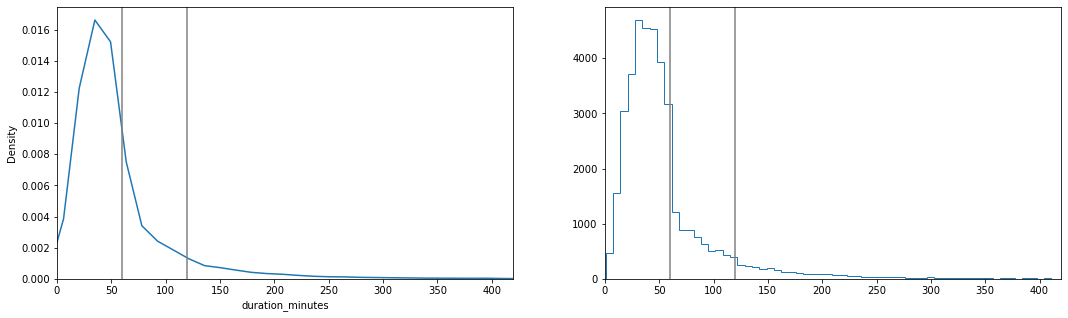

In [20]:
xmax  = 420

fig, axs = plt.subplots(1,2,figsize=(18,5))
sns.kdeplot(data.duration_minutes, ax = axs[0])
axs[0].axvline(60, color  = 'grey')
axs[0].axvline(120, color  = 'grey')
axs[0].set_xlim(0,xmax)

axs[1].hist(data.duration_minutes, histtype = 'step', bins = xmax)
axs[1].axvline(60, color  = 'grey')
axs[1].axvline(120, color  = 'grey')
axs[1].set_xlim(0,xmax)

## estimation

In [21]:
# bunching at x = 60
bsize = 1
ex_reg = 10
ex_reg_miss = 20
z = 60
z_lower60 = z - bsize*ex_reg

missing60 = z + ex_reg_miss*bsize

bunch60 = tools.bunching(data.duration_minutes, bsize = bsize, xmax= 115, xmin= 0, z_upper= z, z_lower= z_lower60, missing = missing60, ex_reg= ex_reg, ex_reg_miss=ex_reg_miss, poly_dgr=6)
#print(bunch60.df_count())

display(bunch60.estimation_res())

print('EX:', bunch60.get_deltaX(), 'mX:', bunch60.get_mX(), 'B:', bunch60.get_B())

pred60 = bunch60.prediction()

print('total bunching',bunch60.total_bunch())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nobs   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     517.5
Date:                Thu, 16 Sep 2021   Prob (F-statistic):           2.95e-81
Time:                        09:24:33   Log-Likelihood:                -584.91
No. Observations:                 115   AIC:                             1188.
Df Residuals:                     106   BIC:                             1213.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     32.5628     24.692      1.319      0.190     -16.391      81.517
duration      -7.2161      6.529     -1.105      0.272     -20.160       5.728
duration2      3.5168      0.532      6.610      0.000       2.462       4.571
duration3     -0.1339      0.018     -7.394      0.000      -0.170      -0.098
duration4      0.0020      0.000      6.863      0.000       0.001       0.003
duration5   -1.33e-05   2.19e-06     -6.084      0.000   -1.76e-05   -8.96e-06
duration6   3.341e-08   6.27e-09      5.331      0.000     2.1e-08    4.58e-08
b            110.1144     20.994      5.245      0.000      68.491     151.737
m            -62.8134     19.770     -3.177      0.002    -102.009     -23.618
==============================================================================
Omnibus:                       26.306   Durbin-Watson:                   0.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.396
Skew:                          -0.765   Prob(JB):                     1.56e-17
Kurtosis:                       6.716   Cond. No.                     4.68e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

EX: 2.408284390602264 mX: -5.784891878203596 B: 1052.9209685838887
total bunching 3.186810431722817


In [22]:
# bunching at x = 120
bsize = 1
ex_reg = 2
z = 120
z_lower120 = z - ex_reg * bsize
missing120 = z + ex_reg * bsize

# define bins

bunch120 = tools.bunching(data.duration_minutes, bsize = bsize, xmax= 160, xmin= 90, z_upper= z, z_lower= z_lower120, missing = missing120, ex_reg= ex_reg, ex_reg_miss = ex_reg_miss, poly_dgr=9, include_missing=False)
#print(bunch120.df_count())

display(bunch120.estimation_res())

print('deltaX:', bunch120.get_deltaX())

pred120 = bunch120.prediction()

print('total bunching',bunch120.total_bunch())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nobs   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     73.51
Date:                Thu, 16 Sep 2021   Prob (F-statistic):           3.42e-25
Time:                        09:24:43   Log-Likelihood:                -257.42
No. Observations:                  70   AIC:                             526.8
Df Residuals:                      64   BIC:                             540.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.052e-12   4.21e-12      1.438      0.155   -2.36e-12    1.45e-11
duration   -8.174e-09   5.69e-09     -1.438      0.155   -1.95e-08    3.18e-09
duration2   1.912e-08   1.33e-08      1.438      0.155   -7.44e-09    4.57e-08
duration3   7.769e-07    5.4e-07      1.438      0.155   -3.02e-07    1.86e-06
duration4   1.918e-05   1.33e-05      1.438      0.155   -7.46e-06    4.58e-05
duration5  -3.664e-07   4.23e-07     -0.867      0.389   -1.21e-06    4.78e-07
duration6   2.214e-09   4.97e-09      0.445      0.658   -7.72e-09    1.21e-08
duration7  -3.257e-12   2.58e-11     -0.126      0.900   -5.47e-11    4.82e-11
duration8  -5.886e-15   4.96e-14     -0.119      0.906   -1.05e-13    9.32e-14
duration9  -9.371e-20    2.8e-19     -0.335      0.739   -6.52e-19    4.65e-19
b           -2.82e-12   1.96e-12     -1.438      0.155   -6.74e-12     1.1e-12
==============================================================================
Omnibus:                        3.631   Durbin-Watson:                   1.523
Prob(Omnibus):                  0.163   Jarque-Bera (JB):                3.057
Skew:                           0.507   Prob(JB):                        0.217
Kurtosis:                       3.135   Cond. No.                     1.10e+25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.26e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

deltaX: 0.592569296709006
total bunching 0.5249034467009568


Text(0.5, 0, 'Duration (Minutes)')

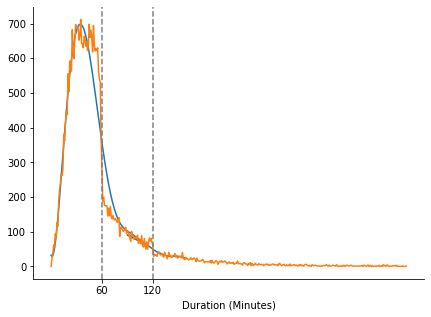

In [23]:
# concat the two predictions
pred = pd.concat([pred60,pred120], ignore_index=True)
xs = tools.bunching(data.duration_minutes, bsize = bsize, xmax= xmax, xmin= 0, z_upper= z, z_lower= z_lower120, missing = missing120, ex_reg= ex_reg, ex_reg_miss = ex_reg_miss, poly_dgr=6, include_missing=False).df_count()


fig, ax = plt.subplots(figsize=(7,5))
plt.plot(pred.duration, pred.y_pred)
plt.plot(xs.duration, xs.nobs)
plt.axvline(60, color= 'grey', linestyle = 'dashed')
plt.axvline(120, color= 'grey', linestyle = 'dashed')
plt.xticks(ticks = [60, 120])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Duration (Minutes)')

63.0


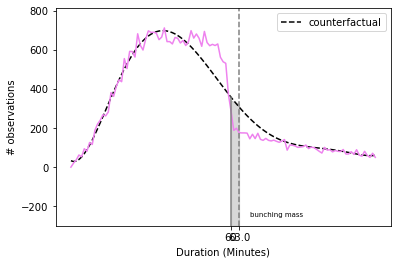

In [24]:
fig, ax = plt.subplots()
b = np.round(60 + bunch60.total_bunch())
print(b)
min = -300
plt.plot(pred60.duration[pred60.duration >= 0], pred60.y_pred[pred60.duration >= 0], color = 'black', linestyle='dashed', label = 'counterfactual')
plt.plot(pred60.duration, pred60.nobs, color = 'violet')
#plt.axvline(60,color='grey', linestyle = 'dashed')
plt.plot([60,60], [min,pred60.loc[pred60.duration == 60, 'y_pred'].reset_index(drop=True)[0]], color = 'grey')
#plt.plot([b,b], [min,pred60.loc[pred60.duration == b, 'y_pred'].reset_index(drop=True)[0]], color = 'grey')
plt.axvline(b,color='grey', linestyle = 'dashed')
plt.xlabel('Duration (Minutes)')
plt.ylabel('# observations')
plt.xticks([60 , b], labels = [60,b])
#plt.xlim(40,100)
plt.ylim(min,pred60.nobs.max()+ 100)
plt.fill_between(np.linspace(60,b,np.sum((pred60.duration > 60) & (pred60.duration < b))),pred60.y_pred[(pred60.duration > 60) & (pred60.duration < b)], np.repeat(min,np.sum((pred60.duration > 60) & (pred60.duration < b))), alpha = .3, color = 'grey')
plt.annotate('bunching mass', xy = (67,min + 50), size = 7)
plt.legend()

#fig.savefig('xdensity.png',dpi=120, format='png')

In [25]:
### solve for alpha
a = symbols('a')
delta_x = bunch60.total_bunch()
def sigmaI(a):
    return (60 + delta_x)*(pi)**(1/(1+a))

def  xI(a):
    return  sigmaI(a) * (pi+phi)**(-1/(1+a))

def L(a):
    return tools.K(xI(a), sigmaI(a), pi=pi, phi=phi, phi120 = phi,alpha=a)
    

def R(a):
    return pi*60 + tools.C(60, sigmaI(a), a) 

def solution(a):
    return L(a) - R(a)
res = fsolve(solution, 90)
alpha = res[0]
print('alpha:',alpha, 'deltax', delta_x)

alpha: 6.766646890267263 deltax 3.186810431722817


In [31]:
# first need to get the counterfactuals on the outage-level
cf = pd.concat([pred60,pred120], ignore_index=True)
cf = cf.loc[:,['bin', 'nobs', 'duration', 'b', 'm','y_pred']]

cf['difference'] = cf.nobs - cf.y_pred
upper60 = 60 + bunch60.total_bunch() + bsize
upper120 = 120 + bunch120.total_bunch() +bsize # make sure that at least one bin is in missing 
cf['b60'] = cf.apply(lambda row: 1 if (row.b ==1) & (row.duration <= missing60) else 0, axis = 1)
cf['missing60'] = cf.apply(lambda row: 1 if (row.duration > 60) & (row.duration <= upper60) else 0, axis = 1)
cf['b120'] = cf.apply(lambda row: 1 if (row.b ==1) & (row.duration >= z_lower120) else 0, axis = 1)
cf['missing120'] = cf.apply(lambda row: 1 if (row.duration > 120) & (row.duration <= upper120) else 0, axis = 1)

# calculate 
sum60 = cf.loc[(cf.duration > 60) & (cf.duration <= upper60),'y_pred'].sum()
sum120 = cf.loc[(cf.duration > 120) & (cf.duration <= upper120),'y_pred'].sum()

#print(sum60,sum120)
cf['prob'] = 0
cf.loc[(cf.duration > 60) & (cf.duration <= upper60), 'prob'] = cf.y_pred / sum60
cf.loc[(cf.duration > 120) & (cf.duration <= upper120), 'prob'] = cf.y_pred / sum120

print(cf.prob.sum() == 2)
cf[(cf.b60 == 1) | (cf.b120 == 1) | (cf.missing120 == 1) | (cf.missing60 == 1)]

True


,bin,nobs,duration,b,m,y_pred,difference,b60,missing60,b120,missing120,prob
50,"(50, 51)",694,50,1,0,535.662036,158.337964,1,0,0,0,0.000000
51,"(51, 52)",637,51,1,0,518.169704,118.830296,1,0,0,0,0.000000
52,"(52, 53)",621,52,1,0,500.372577,120.627423,1,0,0,0,0.000000
53,"(53, 54)",628,53,1,0,482.359164,145.640836,1,0,0,0,0.000000
54,"(54, 55)",622,54,1,0,464.215302,157.784698,1,0,0,0,0.000000
55,"(55, 56)",630,55,1,0,446.023826,183.976174,1,0,0,0,0.000000
56,"(56, 57)",562,56,1,0,427.864256,134.135744,1,0,0,0,0.000000
57,"(57, 58)",539,57,1,0,409.812517,129.187483,1,0,0,0,0.000000
58,"(58, 59)",531,58,1,0,391.940679,139.059321,1,0,0,0,0.000000
59,"(59, 60)",371,59,1,0,374.316714,-3.316714,1,0,0,0,0.000000


In [32]:

## difference in b60 need to be distributed to missing mass

data['duration_cf'] = data.duration_minutes

dict = {'60': cf.loc[(cf.b60 ==1) & (cf.difference >0),].index, '120': cf.loc[(cf.b120 ==1) & (cf.difference >0),].index}
dict_m = {'60': cf.missing60, '120':cf.missing120}

for d in ['60','120']:
    ind = dict[d]
    m = dict_m[d]
    for b in ind:
        # select bin
        bin = cf.bin[b]   
        # get 'extra' observations
        diff = np.round(cf.difference[b]).astype(int)
        #print(bin, diff)
        # extract the data in bin and select n = diff random values
        new_data = data.loc[(data.duration_cf >= bin[0]) & (data.duration_cf < bin[1])].sample(n = diff, axis = 0)
        # now randomly choose a bin in the missing mass, weighted by prob of bin
        mis = cf.loc[m == 1,].sample(n=1, axis =0, weights = cf.prob).bin.reset_index(drop=True)[0]
        # create n=diff random values in bin
        new = np.random.uniform(mis[0], mis[1], size = diff)
        # replace values in new_data
        data.loc[new_data.index.tolist(),'duration_cf'] = new



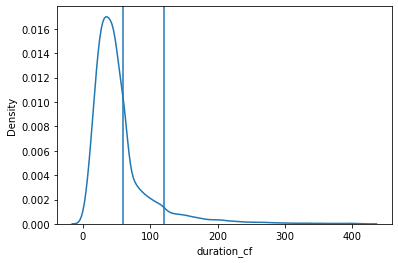

In [34]:
# should look similar to counterfactual density from bunching estimation
sns.kdeplot(data.duration_cf[data.duration_cf < xmax])
plt.axvline(60)
plt.axvline(120)

In [ ]:
# now we can calculate the sigma based on the counterfactual x's

# this takes some computation time

data['sigma'] = 0

for i in data.index:
    s = symbols('s')
    x = data.loc[i, 'duration_cf']
    if x < 60:
        exp = Eq(tools.xopt(s, pi = pi, phi=0, alpha = alpha), x)
        res = solve(exp,s)
    elif x < 120:
        exp = Eq(tools.xopt(s, pi = pi, phi=phi, alpha = alpha), x)
        res = solve(exp,s)
    else:   
        exp = Eq(tools.xopt(s, pi = pi, phi=phi120, alpha = alpha), x)
        res = solve(exp,s)
    data.loc[i,'sigma'] = res[0]

#data

count    38730.000000
mean       100.347909
std        114.067764
min          1.734970
25%         50.314140
50%         76.107366
75%        108.663824
max       4910.495519
Name: sigma, dtype: float64

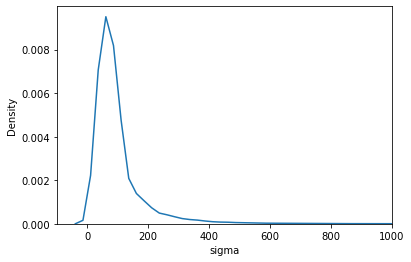

In [ ]:
sns.kdeplot(x =data.sigma.astype(float))
plt.xlim(-100,1000)
data.sigma.astype(float).describe()

$K(\sigma,\pi, \phi) = (\pi + \phi)^{\alpha / (1+\alpha)} \sigma (1 + 1/\alpha)$

In [ ]:
# calculate K 

# method 1: use function tools.K
data['cost_cf'] = data.apply(lambda row: tools.K(row.duration_cf, sigma = row.sigma, pi = pi, phi=phi, phi120=phi120, alpha = alpha), axis = 1)
data['cost_real'] = data.apply(lambda row: tools.K(row.duration_minutes,sigma = row.sigma, pi = pi, phi=phi, phi120=phi120, alpha = alpha), axis = 1)

# method 2: take formular only as a function of sigma
#

# get difference
print(data.cost_real.sum() - data.cost_cf.sum(),'should be posivite to be welfare increasing')

786239.038159341 should be posivite to be welfare increasing


# Utility of consumer  𝑖  experiencing an outage:

$U_i=\delta T−\pi (T-x)−(p' + \chi)x $

T is total time (e.g. 24 hours)

Assumptions:

1-  𝑝′≥𝑝 

2- pollution during an outage is only local

Utility of consumer not experiencing an outage:
$U_i = \delta T - p T - \chi \sum_{i} x_{-i} $

In [ ]:
# total time
T = 14*365

# health cost
chi = 500


pprime = 10 # just a placeholder

### need to multiply by affected consumers
### change in CS: xbunch and xcounter

data['CS_cf'] = data.apply(lambda row: (pi * (T-row.duration_cf) + (pprime + chi)*row.duration_cf) * row.noofcustomersaffected, axis = 1)

data['CS_real'] = data.apply(lambda row: (pi * (T-row.duration_minutes) + (pprime + chi)*row.duration_minutes) * row.noofcustomersaffected, axis = 1)


# get difference
print(data.CS_cf.sum() - data.CS_real.sum(), 'should be posivite to be welfare increasing')

6059613518.703125 should be posivite to be welfare increasing
